La deuxième partie de ce tutoriel sera essentiellement consacrée à la création d'un diagramme de Voronoï à partir des maternités géolocalisées dans le précédent tutoriel.

## Qu'est-ce qu'un diagramme de Voronoï ?

Pour le dire vite, le calcul d'un diagramme de Voronoï consiste **à dresser un dallage à partir de points dans un espace à deux dimensions**. La principale contrainte est d'arriver à avoir des "zones d'influence" de chaque point, **chaque point de la zone étant plus proche du point de référence que de n'importe quel autre point**.

Cela paraît très théorique décrit ainsi, mais **ce genre de configurations se rencontre dans la nature**, par exemple dans de banales têtes d'ail :

![Une tête d'ail illustre à merveille un diagramme de Voronoï](pictures/garling_voronoi.jpg "Photo : Popolon sur Wikipedia")

<center><i>Photo : Popolon sur Wikipedia</i></center>

Dans le cas des maternités, chaque zone sera liée à la maternité la plus proche à vol d'oiseau. D'autrs découpages auraient pu être défendus (par exemple avec les communautés de communes), mais j'avais une petite préférence pour le Voronoï, qui est bien implanté en Python avec [le module geovoronoi](https://pypi.org/project/geovoronoi/).

Ce préambule énoncé, nous pouvons importer les modules utiles dans notre recette :

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from geovoronoi import voronoi_regions_from_coords

Nous allons réimporter le calque de Bretagne celtique créé précédemment :

In [2]:
bzh_calque = gpd.read_file("raw/contours_bzh.json")
bzh_calque

,region,geometry
0,Bretagne,"MULTIPOLYGON (((-4.83581 48.03216, -4.83679 48..."


Il nous faut à présent **des points à superposer afin de dresser notre dallage**. Nous nous focaliserons sur les maternités de 2000 dans ce calepin, mais c'est bien 2023 qui est retenu dans le script 1_geovoronoi.py de ce repo :

In [3]:
mat = gpd.read_file("data/mat.json")
# pour avoir 2023, il suffit de mettre à jour le filtre sur la colonne "2023"
mat_00 = mat[mat["2000"]!=0].reset_index(drop=True)
mat_00

,NOM,STATUT,FI_ET,NOMCOM,ADRESSE,2000,2023,geometry
0,C.H.R. DE NANTES,PUBLIC,440000271,NANTES,1 PLACE ALEXIS RICORDEAU,3089,3962,POINT (-1.5547 47.20917)
1,CLINIQUE NOTRE-DAME-DE-GRACE,PRIVE LUCRATIF,440000446,NANTES,8 RUE FRANCIS MERLANT,2646,0,POINT (-1.57454 47.22136)
2,C.O.P. DE BREQUIGNY,PRIVE LUCRATIF,350003984,RENNES,2 AVENUE D'IRLANDE,2494,0,POINT (-1.6846 48.08752)
3,POLYCLINIQUE DE L ATLANTIQUE,PRIVE LUCRATIF,440033819,ST HERBLAIN,AVENUE CLAUDE BERNARD,2455,3438,POINT (-1.6127 47.22614)
4,C.H.R. : HOPITAL SUD,PUBLIC,350007084,RENNES,16 BOULEVARD DE BULGARIE,2347,3694,POINT (-1.65303 48.08299)
5,CENTRE HOSPITALIER DE ST-BRIEUC,PUBLIC,220000012,ST BRIEUC,10 RUE MARCEL PROUST,2091,1951,POINT (-2.75155 48.49427)
6,C.H.R. : HOTEL DIEU,PUBLIC,350000014,RENNES,2 RUE DE L'HOTEL DIEU,1959,0,POINT (-1.67907 48.11844)
7,HOPITAL CHUBERT- VANNES,PUBLIC,560000127,VANNES,20 BOULEVARD GUILLAUDOT,1891,1930,POINT (-2.74378 47.66346)
8,ET. SOINS LA-SAGESSE RENNES,PRIVE NON LUCRATIF,350000139,RENNES,4 PLACE SAINT GUENOLE,1886,3533,POINT (-1.71293 48.10052)
9,POLYCLINIQUE DE KERAUDREN,PRIVE LUCRATIF,290019777,BREST,RUE ERNESTINE DE TREMAUDAN,1859,1712,POINT (-4.47666 48.42771)


Les deux ingrédients principaux de notre recette semblent réunis, mais autant faire une visualisation pour bien vérifier que rien ne dépasse :

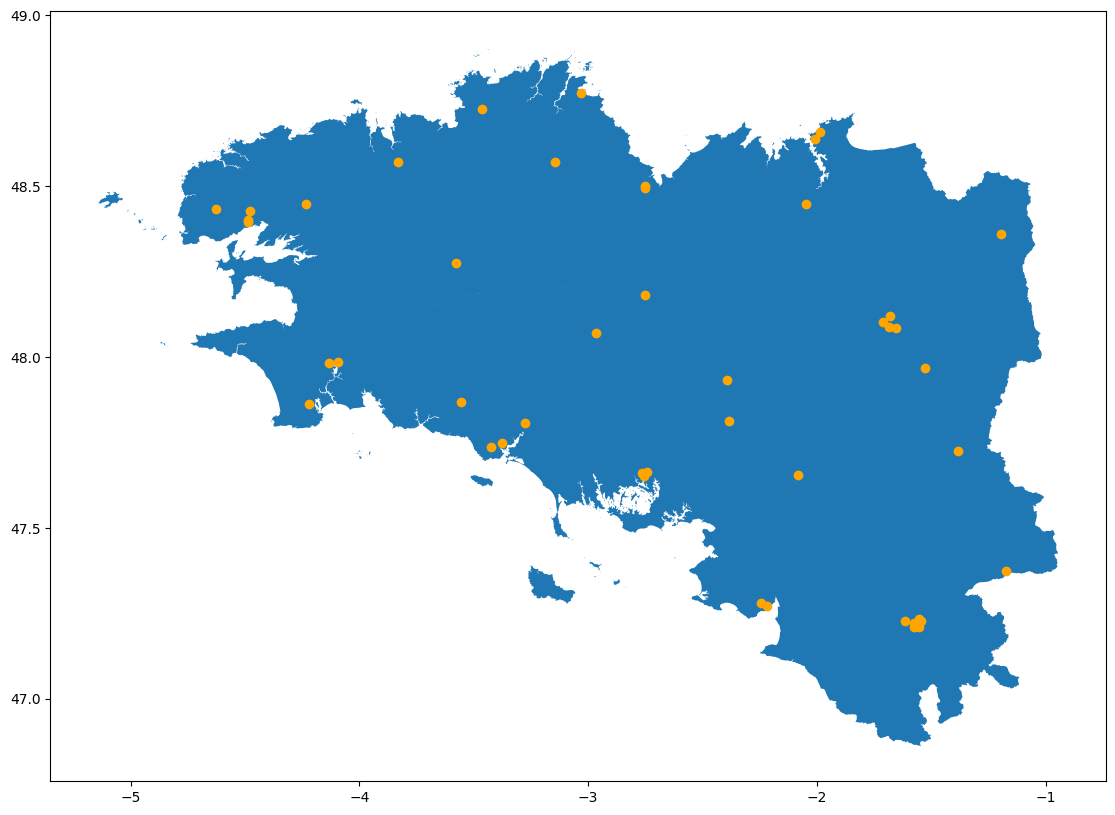

In [4]:
fig, ax = plt.subplots(figsize=(20,10))
bzh_calque.plot(ax=ax)
mat_00.plot(ax=ax,color="orange");

Aucun point situé à l'extérieur de notre calque de référence, les éléments sont bien disposés. Afin que tout soit optimal du côté geovoronoi, nous allons devoir **créer une nouvelle colonne dans la GeoDataFrame mat_00**. A chaque ligne, le même format attendu : **une liste Python \[x,y\]**, où x correspond à la longitude d'une maternité et y à sa latitude.

Cela peut se faire de façon assez simple en utilisant une compréhension de liste qui va directement exploiter la colonne "geometry", et **réagencer ses informations** :

In [5]:
mat_00["coords"] = [[x,y]
                    for x,y
                    in zip(list(mat_00["geometry"].x),
                           list(mat_00["geometry"].y))]
mat_00

,NOM,STATUT,FI_ET,NOMCOM,ADRESSE,2000,2023,geometry,coords
0,C.H.R. DE NANTES,PUBLIC,440000271,NANTES,1 PLACE ALEXIS RICORDEAU,3089,3962,POINT (-1.5547 47.20917),"[-1.5547, 47.2091719]"
1,CLINIQUE NOTRE-DAME-DE-GRACE,PRIVE LUCRATIF,440000446,NANTES,8 RUE FRANCIS MERLANT,2646,0,POINT (-1.57454 47.22136),"[-1.5745386, 47.2213603]"
2,C.O.P. DE BREQUIGNY,PRIVE LUCRATIF,350003984,RENNES,2 AVENUE D'IRLANDE,2494,0,POINT (-1.6846 48.08752),"[-1.6846002, 48.0875238]"
3,POLYCLINIQUE DE L ATLANTIQUE,PRIVE LUCRATIF,440033819,ST HERBLAIN,AVENUE CLAUDE BERNARD,2455,3438,POINT (-1.6127 47.22614),"[-1.6127034, 47.2261389]"
4,C.H.R. : HOPITAL SUD,PUBLIC,350007084,RENNES,16 BOULEVARD DE BULGARIE,2347,3694,POINT (-1.65303 48.08299),"[-1.6530317, 48.0829887]"
5,CENTRE HOSPITALIER DE ST-BRIEUC,PUBLIC,220000012,ST BRIEUC,10 RUE MARCEL PROUST,2091,1951,POINT (-2.75155 48.49427),"[-2.7515542, 48.4942743]"
6,C.H.R. : HOTEL DIEU,PUBLIC,350000014,RENNES,2 RUE DE L'HOTEL DIEU,1959,0,POINT (-1.67907 48.11844),"[-1.6790731, 48.1184378]"
7,HOPITAL CHUBERT- VANNES,PUBLIC,560000127,VANNES,20 BOULEVARD GUILLAUDOT,1891,1930,POINT (-2.74378 47.66346),"[-2.7437802, 47.6634645]"
8,ET. SOINS LA-SAGESSE RENNES,PRIVE NON LUCRATIF,350000139,RENNES,4 PLACE SAINT GUENOLE,1886,3533,POINT (-1.71293 48.10052),"[-1.7129338, 48.1005152]"
9,POLYCLINIQUE DE KERAUDREN,PRIVE LUCRATIF,290019777,BREST,RUE ERNESTINE DE TREMAUDAN,1859,1712,POINT (-4.47666 48.42771),"[-4.476655, 48.4277062]"


Cette nouvelle colonne est conforme à ce que nous attenditions, nous pouvons désormais la réexploiter dans une fonction de geovoronoi.

Deux subilités avant de déclencher la cellule de code :
* les **cordonnées doivent être rassemblées dans un tableau Numpy**. Une compréhension de liste rendra cette contrainte indolore
* même si la GeoDataFrame bzh_calque n'a qu'une seule entrée, il faut explicitement pointer sa géométrie à l'aide [d'une location d'index](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html)

Et ensuite nous déroulons comme suit :

In [6]:
coords = np.array([coords
                   for coords
                   in mat_00["coords"]])
region_polys, region_pts = voronoi_regions_from_coords(coords,
                                                       bzh_calque.iloc[0]["geometry"])

Jetons un coup d'oeil à region_polys :

Cette variable serait bien plus intéressante si elle était formatée en tant que GeoDataFrame. Cette conversion se fera très facilement en créant une nouvelle variable qui interrogera les bonnes parties de region_polys :

In [7]:
polys = gpd.GeoDataFrame([k
                          for k
                          in region_polys.keys()],
                          geometry=[v
                                    for v
                                    in region_polys.values()])
polys

,0,geometry
0,0,"MULTIPOLYGON (((-3.85634 47.79099, -3.85639 47..."
1,1,"POLYGON ((-3.59206 48.51794, -3.90467 48.25112..."
2,2,"MULTIPOLYGON (((-3.59206 48.51794, -3.65394 48..."
3,3,"MULTIPOLYGON (((-2.39469 48.64636, -2.39011 48..."
4,4,"MULTIPOLYGON (((-2.96246 48.45497, -2.93923 48..."
5,5,"MULTIPOLYGON (((-3.24722 48.75734, -3.24591 48..."
6,6,"POLYGON ((-4.37493 48.66721, -4.37439 48.66725..."
7,7,"MULTIPOLYGON (((-4.41083 48.10151, -4.40752 48..."
8,8,"POLYGON ((-2.96962 48.33779, -2.40794 48.33578..."
9,9,"POLYGON ((-2.96246 48.45497, -2.69705 48.5083,..."


Vérifions que tout a bien marché, en remplaçant notre calque *Bretagne celtique* par ce fameux diagramme de Voronoï :

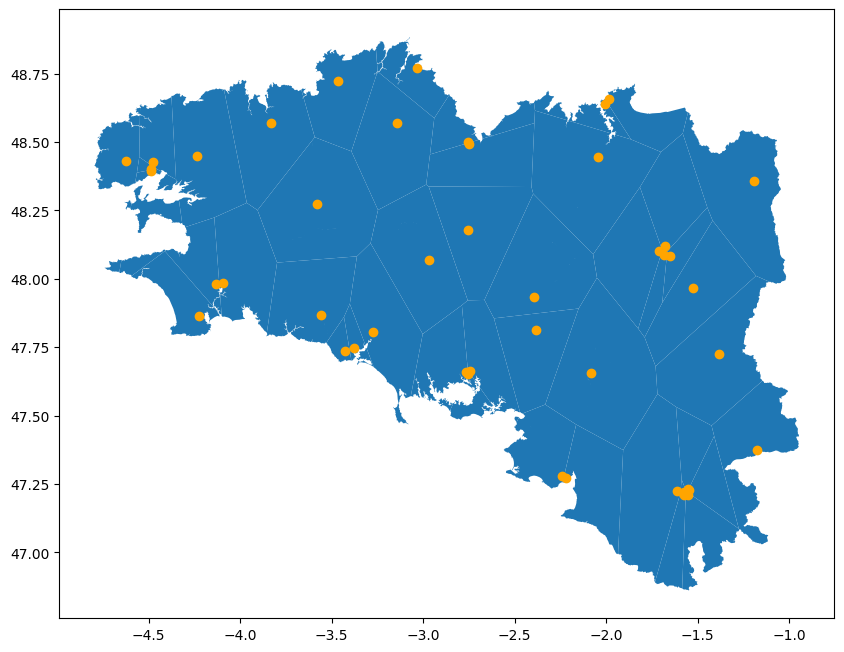

In [10]:
fig, ax = plt.subplots(figsize=(10,20))
polys.plot(ax=ax)
mat_00.plot(ax=ax,color="orange");

C'est conforme, nous pouvons désormais enregistrer

In [9]:
polys.rename(columns={0:"index"},inplace=True)
polys.explode().to_file("raw/voro_mat00_bzh.shp")

C:\Users\raphi\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


## Notes pour la suite

Le fichier n'est pas encore tout à fait parfait, le découpage littéralement à vol d'oiseau fait que nous devons fusionner certaines zones entre elles, par exemple tout à l'Ouest du Finistère.

Je n'ai pas trouvé de solution simple et optimale en pur Python, et me suis donc résolu à utiliser [le logiciel open source QGis](https://qgis.org/) pour ce faire.

Une fois notre fichier vectoriel bien chargé dans QGis, il suffit de sélectionner au moins deux zones, d'appuyer sur le crayon pour annoncer une modification, puis d'aller dans *Editer > Editer les géométries > Fusionner les entités sélectionnées*, d'enregistrer et de passer à la suite.